In [1]:
import iris
import warnings
import iris.plot as iplt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import ks_2samp
import numpy as np
import cmocean

In [2]:
def fxn():
    warnings.warn("user", UserWarning)

warnings.simplefilter("ignore")
fxn()

In [3]:
def ks(data1,data2):
    nt,ny,nx = data1.shape
    return [[ np.nan if data1.mask[0,i,j] else ks_2samp(data1[:,i,j],data2[:,i,j]).statistic  for j in range(nx)] for i in range(ny)]

In [6]:
trials = {'r2':'cg282_ACCESS-CM2_historical_1979_r4p','r6':'cg282_ACCESS-CM2_historical_1979_r6p','agcd':'agcd_tot'}
path = '/short/tp28/eh6215/daily/{trial}/{year:04d}*.nc'
years  = np.arange(1980,1990)
cx = iris.Constraint(longitude=lambda x: 110<=x<=155)
cy = iris.Constraint(latitude =lambda y: -45<=y<=-10)
data = {}

In [11]:
data = {}
for trial in ['r2','agcd']:
    print(trial)
    data[trial]=iris.load([path.format(trial=trials[trial],year=year) for (year) in [1981]])
    iris.util.equalise_attributes(data[trial])
    data[trial]=data[trial].concatenate()

data['agcd'][0].units='mm/day'

r2
agcd


In [36]:
path_drs = "/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/pr/"
data['r6'] =  iris.load([path_drs+'pr_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_%04d0101-%04d1231.nc'%(year,year) for year in years],cx&cy)
iris.util.equalise_attributes(data['r6'])
data['r6'] = data['r6'].concatenate()
data['r6'][0].units = "mm/s"
data['r6'][0].convert_units("mm/day")

In [19]:
cmip_path = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/pr/gn/latest/"
ct = iris.Constraint(time=lambda t: t.point.year in years)
data['ACCESS-CM2'] = iris.load(cmip_path+"pr_day_ACCESS-CM2_historical_r4i1p1f1_gn_19500101-19991231.nc",ct&cy&cx)
data['ACCESS-CM2'][0].units = "mm/s"
data['ACCESS-CM2'][0].convert_units("mm/day")
data['ACCESS-CM2'][0] = data['ACCESS-CM2'][0].regrid(data['r2'][0],iris.analysis.Linear())
print(data)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(


{'r2': [<iris 'Cube' of prcp / (mm/day) (time: 365; latitude: 356; longitude: 291)>], 'agcd': [<iris 'Cube' of agcd_precip / (mm/day) (time: 365; latitude: 250; longitude: 300)>], 'ACCESS-CM2': [<iris 'Cube' of precipitation_flux / (mm/day) (time: 3653; latitude: 356; longitude: 291)>]}


In [17]:
print(data['agcd'][0].coord('latitude').coord_system)

GeogCS(semi_major_axis=6378137.0, semi_minor_axis=6356752.314897855)


In [ ]:
# Precip
proc = {}
agcd_75 = data['agcd'].extract('agcd_precip')[0].extract(cx&cy).data[:,:,1:]
agcd_75.sort(axis=0)
for i,trial in enumerate(trials):
    print(trial)
    proc[trial] = {}
    p = data[trial].extract(['prcp','agcd_precip','precipitation_flux'])[0]
    p = p.extract(cx&cy)
    proc[trial]['mean_rain'] = p.collapsed('time',iris.analysis.MEAN)
    proc[trial]['rain_days'] = p.collapsed('time',iris.analysis.PROPORTION,function=lambda x: x>=1)
    if trial !='agcd':
        p_75 = p.data
        p_75.sort(axis=0)
        proc[trial]['kstest'] = p[0].copy(data=ks(agcd_75[-100:],p_75[-100:]))
                               
    # mean rain
    # rain days
    # 

r2


In [ ]:
proc['agcd']['kstest']=0
proc['agcd']['mean_rain'].units = 'mm/day'
plot = {'mean_rain':(0,5,-2,2,cmocean.cm.rain),'rain_days':(0,.5,-0.2,0.2,cmocean.cm.rain),'kstest':(0,0,0,1,cmocean.cm.dense)}
fig = plt.figure(figsize=(18,8))
for i,var in enumerate(['mean_rain','rain_days']):
    for j,trial in enumerate(['agcd','r2','r6']):
        vmin,vmax,vd1,vd2,cmap=plot[var]
        if trial == 'agcd':
            ax=plt.subplot(3,3,i*3+j+1,projection=ccrs.PlateCarree())
            iplt.pcolormesh(proc[trial][var],vmin=vmin,vmax=vmax,cmap=cmap)
            plt.colorbar()
            plt.title("AGCD")
            ax.coastlines()
            ax.text(-0.07, 0.55, ["Mean rainfall (mm/day)","Rain day fraction (>1mm/day)"][i], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes)

        else:
            ax=plt.subplot(3,3,i*3+j+1,projection=ccrs.PlateCarree())
            tmp = proc[trial][var].copy(data= proc[trial][var].data-proc['agcd'][var].data[:,:-1])
            iplt.pcolormesh(tmp,vmin=vd1,vmax=vd2,cmap='bwr_r')      
            plt.colorbar()
            plt.title("%s: %0.3f"%(trial,np.sqrt(tmp.data**2).mean()) )
            ax.coastlines()
            
for j,trial in enumerate(['r2','r6']):    
    ax=plt.subplot(3,3,j+8,projection=ccrs.PlateCarree())
    iplt.pcolormesh(proc[trial]['kstest'],vmin=0,vmax=0.5,cmap=cmocean.cm.dense_r)  
    plt.title("%s: %0.2f"%(trial,np.nanmean(proc[trial]['kstest'].data)))
    plt.colorbar()
    ax.coastlines()
    if j==0:
        ax.text(-0.07, 0.55, 'KS Stat (top 75 days)', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)



(DimCoord(array([109.974495], dtype=float32), bounds=array([[109.89725, 110.05174]], dtype=float32), standard_name='longitude', units=Unit('degrees'), long_name='longitude', var_name='longitude', coord_system=GeogCS(semi_major_axis=6378137.0, semi_minor_axis=6356752.314897855)),
 DimCoord(array([110.129], dtype=float32), bounds=array([[110.05175 , 110.206245]], dtype=float32), standard_name='longitude', units=Unit('degrees'), long_name='longitude', var_name='longitude'))

In [78]:
agcd_75.shape,p_75.shape

((365, 227, 292), (365, 227, 291))

In [80]:
ks_2samp(agcd_75[-75:,:,1:].filled(0),p_75[-75:].filled(0))

np.apply_along_axis(ks_2sap

ValueError: object too deep for desired array

{'r1': [<iris 'Cube' of Tmax / (Celsius) (time: 365; latitude: 356; longitude: 291)>,
 <iris 'Cube' of Tmin / (Celsius) (time: 365; latitude: 356; longitude: 291)>,
 <iris 'Cube' of dewpt / (Celsius) (time: 365; latitude: 356; longitude: 291)>,
 <iris 'Cube' of doyr / (1) (time: 365)>,
 <iris 'Cube' of int_q / (unknown) (time: 31; latitude: 356; longitude: 291)>,
 <iris 'Cube' of int_q / (unknown) (time: 335; latitude: 356; longitude: 291)>,
 <iris 'Cube' of latent / (W m-2) (time: 365; latitude: 356; longitude: 291)>,
 <iris 'Cube' of low_cloud / (1) (time: 30; latitude: 356; longitude: 291)>,
 <iris 'Cube' of low_cloud / (1) (time: 335; latitude: 356; longitude: 291)>,
 <iris 'Cube' of max_wind / (m s-1) (time: 365; latitude: 356; longitude: 291)>,
 <iris 'Cube' of mean_wind / (m s-1) (time: 365; latitude: 355; longitude: 291)>,
 <iris 'Cube' of prcp / (mm/day) (time: 365; latitude: 356; longitude: 291)>,
 <iris 'Cube' of sfc_pres_pm / (Pa) (time: 365; latitude: 356; longitude: 291)>

In [5]:
#mask = topo.data<=0
topo=iris.load_cube("/home/548/eh6215/orog.nc",cx&cy)
mask = topo.copy(data = np.ma.masked_array(np.ones(topo.shape), mask = topo.data <= 0))
mask.units=1
mask.rename("mask")
mask.remove_coord('time')
years = [2012,2013]
data['ref'] = iris.cube.CubeList()
for var in ['Tmax','Tmin']:
    if var=='prcp':
        data['ref'].append(iris.load(["/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_%d.nc"%year for year in years],cx&cy))
    else:
        data['ref'].append(iris.load(["/g/data/zv2/agcd/v1/{t}/mean/r005/01month/agcd_v1_{t}_mean_r005_monthly_{year}.nc".format(year=year,t=var.lower()) for year in years],cx&cy))
    iris.util.equalise_attributes(data['ref'][-1] )
    data['ref'][-1] =data['ref'][-1] .concatenate_cube()
    data['ref'][-1].coord('longitude').coord_system=None
    data['ref'][-1].coord('latitude').coord_system=None
    data['ref'][-1] =data['ref'][-1].regrid(data['r4'][0],iris.analysis.Linear(extrapolation_mode='mask'))[8:8+12]
    data['ref'][-1].rename(var)

In [21]:
ct = {"DJF":iris.Constraint(time=lambda t:t.point.month in [12,1,2]),'JJA':iris.Constraint(time=lambda t:t.point.month in [6,7,8])}
T = {}
for seas in ['DJF','JJA']:
    for var in ['Tmax','Tmin']:
        T[var+'_'+seas] = {}
        for trial in ['ref','r1','r2','r4','r6']:
            T[var+'_'+seas][trial] = data[trial].extract_cube(var).extract(ct[seas]).collapsed('time',iris.analysis.MEAN)       
             

In [7]:
T

{'Tmax_DJF': {'ref': <iris 'Cube' of Tmax / (degrees_Celsius) (latitude: 356; longitude: 291)>,
  'r1': <iris 'Cube' of Tmax / (Celsius) (latitude: 356; longitude: 291)>,
  'r2': <iris 'Cube' of Tmax / (Celsius) (latitude: 356; longitude: 291)>,
  'r4': <iris 'Cube' of Tmax / (Celsius) (latitude: 356; longitude: 291)>,
  'r6': <iris 'Cube' of Tmax / (Celsius) (latitude: 356; longitude: 291)>},
 'Tmin_DJF': {'ref': <iris 'Cube' of Tmin / (degrees_Celsius) (latitude: 356; longitude: 291)>,
  'r1': <iris 'Cube' of Tmin / (Celsius) (latitude: 356; longitude: 291)>,
  'r2': <iris 'Cube' of Tmin / (Celsius) (latitude: 356; longitude: 291)>,
  'r4': <iris 'Cube' of Tmin / (Celsius) (latitude: 356; longitude: 291)>,
  'r6': <iris 'Cube' of Tmin / (Celsius) (latitude: 356; longitude: 291)>},
 'Tmax_JJA': {'ref': <iris 'Cube' of Tmax / (degrees_Celsius) (latitude: 356; longitude: 291)>,
  'r1': <iris 'Cube' of Tmax / (Celsius) (latitude: 356; longitude: 291)>,
  'r2': <iris 'Cube' of Tmax / (Cel

Tmax_DJF ref
Tmax_DJF r1
Tmax_DJF r2
Tmax_DJF r4
Tmax_DJF r6
Tmin_DJF ref
Tmin_DJF r1
Tmin_DJF r2
Tmin_DJF r4
Tmin_DJF r6
Tmax_JJA ref
Tmax_JJA r1
Tmax_JJA r2
Tmax_JJA r4
Tmax_JJA r6
Tmin_JJA ref
Tmin_JJA r1
Tmin_JJA r2
Tmin_JJA r4
Tmin_JJA r6


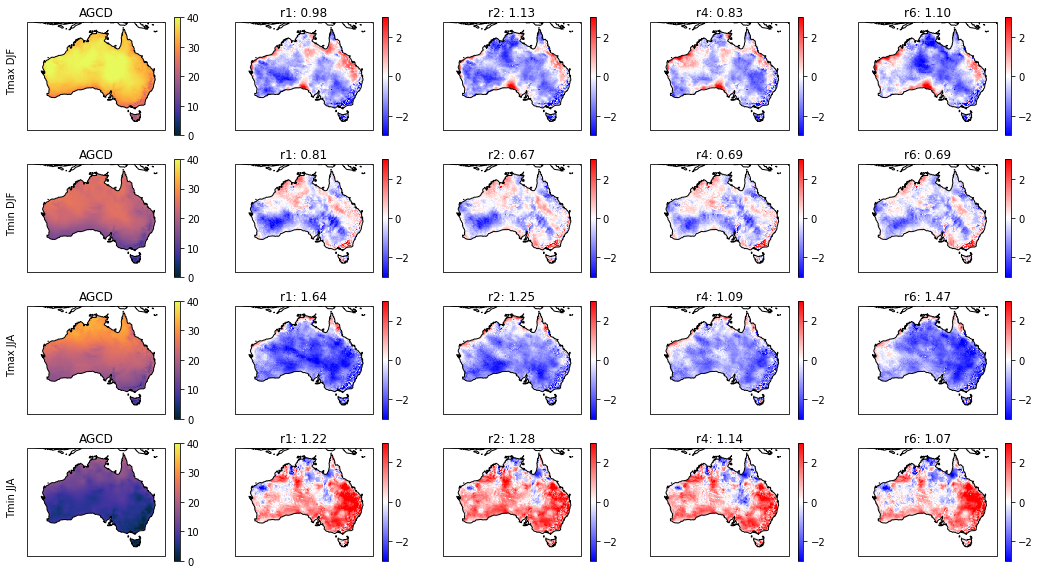

In [25]:
plot = {'Tmin':(0,5,-2,2,cmocean.cm.rain),'Tmax':(0,.5,-0.2,0.2,cmocean.cm.rain),'kstest':(0,0,0,1,cmocean.cm.dense)}
fig = plt.figure(figsize=(18,10))
for i,var in enumerate(T):
    for j,trial in enumerate(['ref','r1','r2','r4','r6']):
        print(var,trial)
        if trial == 'ref':
            ax=plt.subplot(4,5,i*5+j+1,projection=ccrs.PlateCarree())
            tmp = T[var][trial].extract(cx&cy)
            tmp.data.mask +=  data['agcd'].extract('agcd_precip')[0].extract(cx&cy)[0,:,1:].data.mask
            iplt.pcolormesh(tmp,cmap=cmocean.cm.thermal,vmin=0,vmax=40)
            plt.colorbar()
            plt.title("AGCD")
            ax.coastlines()
            ax.text(-0.07, 0.55, var.replace('_'," "), va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes)
        else:
            ax=plt.subplot(4,5,i*5+j+1,projection=ccrs.PlateCarree())
            tmp = T[var][trial].copy(data= T[var][trial].data-T[var]['ref'].data).extract(cx&cy)
            tmp.data.mask +=  data['agcd'].extract('agcd_precip')[0].extract(cx&cy)[0,:,1:].data.mask
            iplt.pcolormesh(tmp,vmin=-3,vmax=3,cmap='bwr')      
            plt.colorbar()
            plt.title("%s: %0.2f"%(trial,np.sqrt(tmp.data**2).mean()) )
            ax.coastlines()
            

In [31]:
data

{'r2': [<iris 'Cube' of prcp / (mm/day) (time: 731; latitude: 356; longitude: 291)>],
 'agcd': [<iris 'Cube' of agcd_precip / (mm/day) (time: 731; latitude: 250; longitude: 300)>],
 'r6': [<iris 'Cube' of precipitation_flux / (mm/day) (time: 731; latitude: 227; longitude: 291)>]}